In [1]:
import sys
sys.path.insert(1, '../scripts')

In [2]:
# data processing
import random
import numpy as np
import pandas as pd
from scipy import stats
from Bio import AlignIO
import alignment_quality as aq
import crutil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
all_aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## Functions

In [5]:
def get_region_msa_from_df(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = row['orf']
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
    return region_msa

In [6]:
def count_aas(msa, position, states):
    aa_count = {}
    for state in states:
        aa_count[state] = 0
    for seq in msa:
        aa = seq.seq[position]
        if aa in states:
            aa_count[aa] += 1
    return aa_count

In [7]:
def get_column_aa_distribution(msa, position, states):
    aa_cnt = count_aas(msa, position, states)
    total_cnt = sum(aa_cnt.values())
    if total_cnt != 0:
        aa_dist = []
        for k,v in aa_cnt.items():
            aa_dist.append(v / total_cnt)
    else:
        aa_dist = None
    return aa_dist

In [8]:
def get_freq_nongaps(msa):
    cntseqs = len(msa)
    freq_nongaps = []
    for i in range(len(msa[0].seq)):
        cnt = 0
        for record in msa:
            if record.seq[i] != '-':
                cnt += 1
        freq_nongaps.append(cntseqs / cnt)
    return freq_nongaps

In [9]:
def get_seq_divergence(msa, states, weighted=True):
    entropy_list = []
    for p in range(len(msa[0].seq)):
        aa_dist = get_column_aa_distribution(msa, p, states)
        if not aa_dist is None:
            entropy_list.append(stats.entropy(aa_dist))
    if weighted:
        weights = get_freq_nongaps(msa)
        S = 0
        for i, entropy in enumerate(entropy_list):
            S += entropy * weights[i]
    else:
        S = sum(entropy_list)
    return S / len(msa)

In [10]:
def append_seq_divergence(row):
    region_msa = get_region_msa_from_df(row)
    filtered_msa = aq.filter_msa(region_msa)
    if len(filtered_msa) >= 1:
        aq.remove_gap_only_indices(filtered_msa)
        seq_div = get_seq_divergence(filtered_msa, all_aa, weighted=True)
    else:
        seq_div = None
    return seq_div

In [11]:
def get_uncharged_region_ranges(charged_regions, msa_len):
    uncharged_regions = []
    
    if charged_regions[0][0] != 0:
        uncharged_regions.append((0, charged_regions[0][0] - 1))
        
    start = charged_regions[0][1] + 1
    for region in charged_regions[1:]:
        uncharged_regions.append((start, region[0]-1))
        start = region[1] + 1

    if charged_regions[-1][1] != (msa_len - 1):
        uncharged_regions.append((charged_regions[-1][1], msa_len-1))
        
    return uncharged_regions

In [12]:
def extract_uncharged_region_msa(msa, charged_regions):
    uncharged_regions = get_uncharged_region_ranges(charged_regions, len(msa[0]))
    for record in msa:
        uncharged_seq = ''
        for region in uncharged_regions:
            uncharged_seq += record.seq[region[0]:(region[1]+1)]
        record.seq = uncharged_seq
    return msa

In [13]:
def append_null_seq_divergence(row):
    orf = row['orf']
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    charged_regions = ranges_dict[orf]
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    regionlen = msa_right_bound - msa_left_bound
    uncharged_region_msa = extract_uncharged_region_msa(msa, charged_regions)
    random_region_msa = aq.extract_random_region_from_msa(uncharged_region_msa, regionlen)
    filtered_msa = aq.filter_msa(random_region_msa)
    if len(filtered_msa) >= 1:
        aq.remove_gap_only_indices(filtered_msa)
        seq_div = get_seq_divergence(filtered_msa, all_aa, weighted=True)
    else:
        seq_div = None
    return seq_div

In [14]:
def extract_random_region_from_proteome(fdir, regionlen, valid_orfs):
    msa = None
    cnt = 0
    while msa is None:
        orf_i = random.randrange(len(valid_orfs))
        orf = valid_orfs[orf_i]
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        if len(msa[0].seq) <= regionlen:
            msa = None
        cnt += 1
        if cnt >= 20:
            print(regionlen)
    starti = random.randrange(len(msa[0].seq) - regionlen)
    random_msa = msa[:, starti:(starti + regionlen)]    
    return random_msa

## Compute alignment quality for all hits - threshold

In [15]:
df = pd.read_csv('../../data/charged_regions/cr_filtered.csv', comment='#')

In [16]:
df['seq.divergence'] = df.apply(lambda row: append_seq_divergence(row), axis=1)

In [17]:
df[df['seq.divergence'].isna()]

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,seq.divergence
62,YBR278W,DPB3,202,108,166,QPGRSDQEVVIEEPELHEDDGVEEEEEEDEVSEEEEPVHNEELLDD...,59,0.273446,0.508475,0.114140,0.416735,P27344,verified,NaN
433,YIL149C,MLP2,1680,60,106,KLKQLLDESSEQKNTAKEELNGLKDQLNEERSRYRREIDALKKQLHV,47,0.001013,0.446809,0.073132,0.185590,P40457,verified,NaN


In [18]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
ranges_dict = {}
for index, row in df.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if orf not in ranges_dict:
        ranges_dict[orf] = []
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    ranges_dict[orf].append((msa_left_bound, msa_right_bound))

In [19]:
df['seq.divergence.random'] = df.apply(lambda row: append_null_seq_divergence(row), axis=1)

In [20]:
verified_orfs_with_msa = pd.read_csv('../../data/sc_orfs/verified_orfs_with_msa.csv')
valid_orfs = verified_orfs_with_msa['systematic_name'].tolist()

In [21]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
sd_random = []
for k,v in ranges_dict.items():
    for charged_region in v:
        regionlen = charged_region[1] - charged_region[0] + 1
        random_msa = extract_random_region_from_proteome(fdir, regionlen, valid_orfs)
        filtered_msa = aq.filter_msa(random_msa)
        if len(filtered_msa) >= 1:
            aq.remove_gap_only_indices(filtered_msa)
            seq_div = get_seq_divergence(filtered_msa, all_aa, weighted=True)
        else:
            seq_div = None
        sd_random.append(seq_div)

In [22]:
df = df.dropna(how='any')

In [23]:
bins = np.arange(0, 150, 5)

## Alignment quality of IDRs

In [24]:
df_disprot = pd.read_table('../../data/misc/search_in_disprot.tsv')

In [25]:
with open('../../data/misc/uniprot-to-sgdid.txt') as f:
    mappings = {}
    for line in f:
        uniprot = line[95:106].rstrip()
        orf = line[75:95].rstrip()
        mappings[uniprot] = orf

In [26]:
df_disprot.head(5)

,acc,name,organism,ncbi_taxon_id,disprot_id,region_id,start,end,term_namespace,term,ec,reference,region_sequence,confidence,obsolete
0,P32774,Transcription initiation factor IIA subunit 2,Saccharomyces cerevisiae (strain ATCC 204508 /...,559292,DP00009,DP00009r001,89,104,Structural state,IDPO:00076,IDPO:00130,pmid:8610010,DSHRDASQNGSGDSQS,NaN,NaN
1,P11938,DNA-binding protein RAP1,Saccharomyces cerevisiae (strain ATCC 204508 /...,559292,DP00020,DP00020r001,1,123,Structural state,IDPO:00076,IDPO:00120,pmid:21187076,MSSPDDFETAPAEYVDALDPSMVVVDSGSAAVTAPSDSAAEVKANQ...,NaN,NaN
2,P11938,DNA-binding protein RAP1,Saccharomyces cerevisiae (strain ATCC 204508 /...,559292,DP00020,DP00020r003,210,359,Structural state,IDPO:00076,IDPO:00120,pmid:21187076,YDNFREVVDSRLQEESHSNGVDNSNSNSDNKDSIRPKTEIISTNTN...,NaN,NaN
3,P11938,DNA-binding protein RAP1,Saccharomyces cerevisiae (strain ATCC 204508 /...,559292,DP00020,DP00020r005,210,359,Structural state,IDPO:00076,IDPO:00120,pmid:8620531,YDNFREVVDSRLQEESHSNGVDNSNSNSDNKDSIRPKTEIISTNTN...,NaN,NaN
4,P11938,DNA-binding protein RAP1,Saccharomyces cerevisiae (strain ATCC 204508 /...,559292,DP00020,DP00020r007,481,511,Structural state,IDPO:00076,IDPO:00130,pmid:8620531,ITDEDTPTAIARRNMTMDPNHVPGSEPNFAA,NaN,NaN


In [27]:
verified_orfs_with_msa = pd.read_csv('../../data/sc_orfs/verified_orfs_with_msa.csv')
valid_orfs = verified_orfs_with_msa['systematic_name'].tolist()

In [28]:
def append_orf_name(row):
    orf = mappings[row['acc']]
    return orf

In [29]:
df_disprot['orf'] = df_disprot.apply(lambda row:append_orf_name(row), axis=1)

In [30]:
df_disprot = df_disprot[df_disprot['orf'].isin(valid_orfs)]

In [31]:
df_disprot = df_disprot.rename(columns={'start': 'left.bound', 'end': 'right.bound', 'region_sequence': 'region.seq'})

In [32]:
df_disprot['seq.divergence'] = df_disprot.apply(lambda row: append_seq_divergence(row), axis=1)

## Summary plots

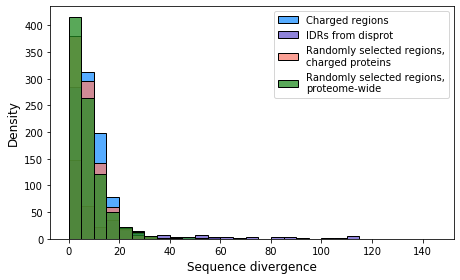

In [33]:
plt.figure(figsize=(6.5,4))
sns.histplot(data=df, x='seq.divergence', color='dodgerblue', common_norm=True, bins=bins)
sns.histplot(data=df_disprot, x='seq.divergence', color='slateblue', common_norm=True, bins=bins)
sns.histplot(data=df, x='seq.divergence.random', color='salmon', common_norm=True, bins=bins)
sns.histplot(sd_random, color='forestgreen', common_norm=True, bins=bins)
plt.xlabel('Sequence divergence', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(['Charged regions',
            'IDRs from disprot',
            'Randomly selected regions,\ncharged proteins',
            'Randomly selected regions,\nproteome-wide'])
plt.tight_layout()
#plt.savefig('./figures/alignment-quality-medthreshold.png', dpi=500)
plt.show()

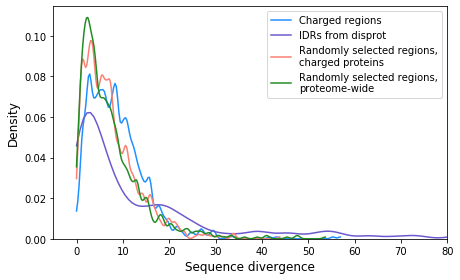

In [34]:
plt.figure(figsize=(6.5,4))
sns.kdeplot(data=df, x='seq.divergence', color='dodgerblue', cut=0, bw_adjust=.3)
sns.kdeplot(data=df_disprot, x='seq.divergence', color='slateblue', cut=0, bw_adjust=.3)
sns.kdeplot(data=df, x='seq.divergence.random', color='salmon', cut=0, bw_adjust=.3)
sns.kdeplot(sd_random, color='forestgreen', cut=0, bw_adjust=.3)
plt.xlabel('Sequence divergence', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(['Charged regions',
            'IDRs from disprot',
            'Randomly selected regions,\ncharged proteins',
            'Randomly selected regions,\nproteome-wide'])
plt.xlim(-5, 80)
plt.tight_layout()
plt.show()